In [1]:
import torch 
import numpy as np
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import optuna
from optuna import trial
from functions import rastrigin, adam_optimizer, sgd_optimizer, BBI_optimizer

In [2]:
def rastrigin_plot(x, A=10):
    D = len(x)
    f = A*D + np.sum(x**2 - A*np.cos(2*np.pi*x))
    df = 2*x + 2*A*np.pi*np.sin(2*np.pi*x)
    return f, df

x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros((len(X), len(Y)))
for i in range(100):
    for j in range(100):
        Z[i,j] = rastrigin_plot(np.array([X[i,j], Y[i,j]]))[0]

fig = go.Figure(data=[go.Surface(x=X, y=Y, z=Z)])
fig.update_layout(
    title='Rosenbrock Function 3D Surface Plot',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',))
fig.show()

In [5]:
n = 10
global_min = torch.zeros(n)
xs = torch.ones(n)

print("Initial value: ", rastrigin(xs)[0])
print("Global minimum: ", rastrigin(global_min)[0])

Initial value:  tensor(10.)
Global minimum:  tensor(0.)


In [10]:
# Tuning function with optuna

tune_iterations = 2500 
n_trials = 50
test_iterations = 4 * tune_iterations
x0 =xs.tolist()

potential = rastrigin
optuna.logging.disable_default_handler()

def hyper_tuning(ranges, ranges_integer, optimizer, tune_iterations=1000, n_trials=100, **fixed_pars):
    def optimizer_func(trial):
        pars = {}
        for par, range in ranges.items(): pars[par] = trial.suggest_float(par, *range)
        for par, range in ranges_integer.items(): pars[par] = trial.suggest_int(par, *range)
        xs, _, _ = optimizer(x0, potential, iterations=tune_iterations, **pars, **fixed_pars)
        return potential(xs)[0]
    study = optuna.create_study(direction='minimize')
    study.optimize(optimizer_func, n_trials=n_trials)
    best = study.best_params
    loss = study.best_value
    return best, loss

best_par_sgd, loss_sgd = hyper_tuning({'lr': [1e-10,.5], 'momentum': [0,1.0]}, {}, sgd_optimizer, tune_iterations=tune_iterations, n_trials=n_trials)
print("sgd:", best_par_sgd, "\t loss:", loss_sgd)

sgd: {'lr': 0.1703544414835527, 'momentum': 0.4710728313454212} 	 loss: 7.62939453125e-06


In [7]:
best_par_adam, loss_adam = hyper_tuning({'lr': [1e-10,.5]},{}, adam_optimizer, tune_iterations=tune_iterations, n_trials=n_trials)
print("adam:", best_par_adam, "\t loss:", loss_adam)

adam: {'lr': 0.49996930093992953} 	 loss: 0.0


In [14]:
best_par_bbi, loss_bbi = hyper_tuning({'lr': [1e-6,1e-1]},{}, BBI_optimizer, tune_iterations=tune_iterations,  n_trials=n_trials*4,
    threshold0 = 20, threshold = 100, deltaEn = 2.0, v0 = 1e-4,  n_fixed_bounces = 4, consEn = True)
print("bbi:", best_par_bbi, "\t loss:", loss_bbi)

bbi: {'lr': 0.05659301549431272} 	 loss: 9.949577331542969


Loss adam: 0.0
Loss sgd: 7.62939453125e-06
Loss bbi: 9.949577331542969


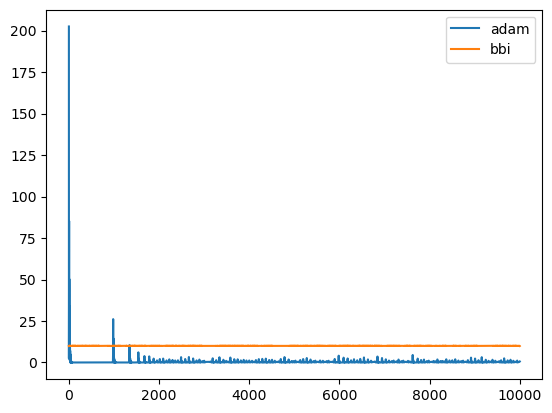

In [16]:
x0 =xs.tolist()
_, xslist_bbi, _ = BBI_optimizer(x0, potential, iterations=test_iterations, **best_par_bbi)
_, xslist_adam, _ = adam_optimizer(x0, potential, iterations=test_iterations, **best_par_adam)
_, xslist_sgd, _ = sgd_optimizer(x0, potential, iterations=test_iterations, **best_par_sgd)

name = ["adam", "sgd", "bbi"]
n = 0
for lists in [xslist_adam, xslist_sgd, xslist_bbi]:
    min_temp = 10e20
    for elem in lists:
        elem_tens_val, _ = rastrigin(torch.tensor(elem))
        if elem_tens_val < min_temp:
            min_temp = elem_tens_val.item()
    print(f"Loss {name[n]}: {min_temp}")
    n += 1

def plotting(f, lists, names):
    n = 0
    for xs_list in lists:
        val = []
        for point in xs_list:
            val.append(f(torch.tensor(point))[0])
        val = torch.stack(val)
        plt.plot(val, label = f"{names[n]}")
        n += 1
    plt.legend()
    plt.show()

plotting(rastrigin, [xslist_adam, xslist_bbi], ["adam", "bbi"])

In [21]:
x0 = [3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]
best, xslist_sgd, trajectory = sgd_optimizer(x0, potential, iterations=test_iterations, **best_par_sgd)

# surface data
x = np.linspace(-30, 30, 100)
y = np.linspace(-30, 30, 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        Z[i,j] = rastrigin_plot(np.array([X[i,j], Y[i,j]]))[0]

# Create the trajectory
trajectory_x = [pos[0] for pos in trajectory]
trajectory_y = [pos[1] for pos in trajectory]
trajectory_z = [rastrigin_plot(np.array([pos[0], pos[1]]))[0] for pos in trajectory]

surface = go.Surface(x=X, y=Y, z=Z, colorscale='Viridis', opacity=0.8)
trajectory = go.Scatter3d(x=trajectory_x, y=trajectory_y, z=trajectory_z, mode='lines', marker=dict(size=4))
layout = go.Layout(scene=dict(xaxis=dict(title='X'), yaxis=dict(title='Y'), zaxis=dict(title='Z')), title='SGD Trajectory in 3D')
fig = go.Figure(data=[surface, trajectory], layout=layout)
fig.show()

In [23]:
x0 = [3.0,3.0,3.0, 3.0]
best, xslist_bbi, trajectory = BBI_optimizer(x0, potential, iterations=test_iterations, **best_par_bbi)

# surface data
x = np.linspace(-13, 13, 100)
y = np.linspace(-13, 13, 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        Z[i,j] = rastrigin_plot(np.array([X[i,j], Y[i,j]]))[0]

# Create the trajectory
trajectory_x = [pos[0] for pos in trajectory]
trajectory_y = [pos[1] for pos in trajectory]
trajectory_z = [rastrigin_plot(np.array([pos[0], pos[1]]))[0] for pos in trajectory]

surface = go.Surface(x=X, y=Y, z=Z, colorscale='Viridis', opacity=0.8)
trajectory = go.Scatter3d(x=trajectory_x, y=trajectory_y, z=trajectory_z, mode='lines', marker=dict(size=4))
layout = go.Layout(scene=dict(xaxis=dict(title='X'), yaxis=dict(title='Y'), zaxis=dict(title='Z')), title='BBI Trajectory in 3D')
fig = go.Figure(data=[surface, trajectory], layout=layout)
fig.show()

In [25]:
x0 = [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
best, xslist_bbi, trajectory = adam_optimizer(x0, potential, iterations=test_iterations, **best_par_adam)

# surface data
x = np.linspace(-30, 30, 100)
y = np.linspace(-30, 30, 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        Z[i,j] = rastrigin_plot(np.array([X[i,j], Y[i,j]]))[0]

# Create the trajectory
trajectory_x = [pos[0] for pos in trajectory]
trajectory_y = [pos[1] for pos in trajectory]
trajectory_z = [rastrigin_plot(np.array([pos[0], pos[1]]))[0] for pos in trajectory]

surface = go.Surface(x=X, y=Y, z=Z, colorscale='Viridis', opacity=0.8)
trajectory = go.Scatter3d(x=trajectory_x, y=trajectory_y, z=trajectory_z, mode='lines', marker=dict(size=4))
layout = go.Layout(scene=dict(xaxis=dict(title='X'), yaxis=dict(title='Y'), zaxis=dict(title='Z')), title='Adam Trajectory in 3D')
fig = go.Figure(data=[surface, trajectory], layout=layout)
fig.show()